# Classification
Erin Cameron  
COSC3117  
2022-11-21
---

In [1]:
# Import the scikit learn library
# !pip3 install scikit-learn

In [308]:
# Import statements
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# 1.0) Define ML train features

~~I noticed a correlation (?) between flight departure times and the cancellation of flights... NOTE: therefore I decided to use continuous variables/features in the dataset to predict cancellation status, instead of discrete variables/features.~~ 

In [11]:
# conVar = ["DepTime", 
#           "DepDelay", 
#           "DepDelayMinutes", 
#           "TaxiOut",
#           ""]

features = ["Airline", 
              "OriginStateName", 
              "OriginCityName", 
              "DestCityName", 
              "DestStateName", 
              "Year", 
              "Quarter", 
              "Month", 
              "DayofMonth", 
              "DayOfWeek", 
              "Distance",
              "CRSDepTime"
             ]

In [12]:
predClass = ["Cancelled"]

# 2.0) Format and Load Dataset

In [13]:
# Read in the merged csv file
data = pd.read_csv("../data/FlightStatusData_Merged_AllYears_20221114.csv")
print("Reading in data...")

Reading in data...


In [14]:
# Subset data to relevent discrete variables and prediction class
data = data[features + predClass]
data.head()

,Airline,OriginStateName,OriginCityName,DestCityName,DestStateName,Year,Quarter,Month,DayofMonth,DayOfWeek,Distance,CRSDepTime,Cancelled
0,Delta Air Lines Inc.,Minnesota,"Minneapolis, MN","Washington, DC",Virginia,2018,4,10,6,6,931.0,1255,False
1,Republic Airlines,Minnesota,"Minneapolis, MN","Newark, NJ",New Jersey,2018,4,10,12,5,1008.0,605,False
2,United Air Lines Inc.,California,"Los Angeles, CA","Denver, CO",Colorado,2018,4,11,26,1,862.0,1047,False
3,Mesa Airlines Inc.,Kentucky,"Louisville, KY","Washington, DC",Virginia,2018,4,11,16,5,451.0,1445,False
4,Delta Air Lines Inc.,Minnesota,"Minneapolis, MN","Salt Lake City, UT",Utah,2018,1,1,26,5,991.0,1730,False


In [15]:
# Updated cancellation status to True = 1, False = 0
data["Cancelled"] = data["Cancelled"].map({True: 1, False: 0})

In [16]:
# Check number of cancelled flights
data["Cancelled"].value_counts()

0    388873
1     11127
Name: Cancelled, dtype: int64

In [17]:
# drop any columns that have missing values for variables (if applicable)
print("Before dropping NAs...Cancellation Status Breakdown")
print(data["Cancelled"].value_counts())
print(data.shape)

print("\n\nAfter dropping NAs...Cancellation Status Breakdown")
data = data.dropna()
print(data["Cancelled"].value_counts())
print(data.shape)

Before dropping NAs...Cancellation Status Breakdown
0    388873
1     11127
Name: Cancelled, dtype: int64
(400000, 13)


After dropping NAs...Cancellation Status Breakdown
0    388873
1     11127
Name: Cancelled, dtype: int64
(400000, 13)


# 3.0) Split into Test and Train

In [18]:
# Split the data into train and test
train_data, test_data = train_test_split(data, test_size = 0.20, random_state = 123)

In [19]:
# Check that train and test are correct size
print("\n\nTraining dataset....80% of original dataset")
print(train_data.shape)
display(train_data.head())

print("\n\nTest dataset....20% of original dataset")
print(test_data.shape)
display(test_data.head())



Training dataset....80% of original dataset
(320000, 13)


,Airline,OriginStateName,OriginCityName,DestCityName,DestStateName,Year,Quarter,Month,DayofMonth,DayOfWeek,Distance,CRSDepTime,Cancelled
43773,Southwest Airlines Co.,Texas,"Houston, TX","New Orleans, LA",Louisiana,2018,2,6,1,5,302.0,1350,0
15146,Southwest Airlines Co.,Nevada,"Las Vegas, NV","Seattle, WA",Washington,2018,3,7,4,3,867.0,1940,0
248689,ExpressJet Airlines Inc.,Texas,"Houston, TX","Baton Rouge, LA",Louisiana,2020,3,8,16,7,253.0,1020,0
130971,"GoJet Airlines, LLC d/b/a United Express",Michigan,"Detroit, MI","Elmira/Corning, NY",New York,2019,2,5,11,6,332.0,856,0
166558,United Air Lines Inc.,New Jersey,"Newark, NJ","Denver, CO",Colorado,2019,1,3,24,7,1605.0,1005,0




Test dataset....20% of original dataset
(80000, 13)


,Airline,OriginStateName,OriginCityName,DestCityName,DestStateName,Year,Quarter,Month,DayofMonth,DayOfWeek,Distance,CRSDepTime,Cancelled
386128,United Air Lines Inc.,California,"San Francisco, CA","Denver, CO",Colorado,2021,4,11,17,3,967.0,900,0
297944,ExpressJet Airlines Inc.,Louisiana,"Lake Charles, LA","Houston, TX",Texas,2020,3,7,31,5,127.0,1745,0
164196,Southwest Airlines Co.,Nevada,"Las Vegas, NV","Oakland, CA",California,2019,1,3,6,3,407.0,1440,0
76962,United Air Lines Inc.,Florida,"Miami, FL","Chicago, IL",Illinois,2018,1,1,29,1,1197.0,1550,0
52185,Southwest Airlines Co.,California,"Sacramento, CA","Los Angeles, CA",California,2018,4,10,25,4,373.0,700,0


# 4.0) Logistic Regression

## 4.1) Data preparation

For categorical/discrete variables, we need to convert into an interger based column to be compatible with logistic regression function.

https://medium.com/@curryrowan/simplified-logistic-regression-classification-with-categorical-variables-in-python-1ce50c4b137



In [27]:
# format the categorical datas into binaries within each class
cats = ["Airline", "OriginStateName", "OriginCityName", 
        "DestCityName", "DestStateName", "Year",
        "Quarter", "Month", "DayofMonth", "DayOfWeek"
       ]

In [28]:
# convert categories into binary columns for each class within categorical variable
train_new_df = {}
test_new_df = {}

for cat in cats:
    train_data[cat] = train_data[cat].astype(str)
    train_new_df[cat] = pd.get_dummies(train_data[cat], prefix = cat + "_")
    
    test_data[cat] = test_data[cat].astype(str)
    test_new_df[cat] = pd.get_dummies(test_data[cat], prefix = cat + "_")
    

In [66]:
# combine data into 1 df
test_data_lr = pd.concat(test_new_df.values(), axis = 1)
train_data_lr = pd.concat(train_new_df.values(), axis = 1)

In [67]:
# make sure test and train dataframe have the same columns in the same order
# if one column is NOT in one of the dfs, add it and fill with 0s
missing_cols = list(set(test_data_lr.columns) ^ set(train_data_lr.columns))

for mCol in missing_cols:
    
    if mCol not in train_data_lr.columns:
        print("===> Adding " + mCol + " to 'train_data_lr'....")
        train_data_lr[mCol] = 0
        
    if mCol not in test_data_lr.columns:
        print("===> Adding " + mCol + " to 'test_data_lr'....")
        test_data_lr[mCol] = 0

===> Adding DestCityName__Wilmington, DE to 'test_data_lr'....
===> Adding OriginCityName__Rota, TT to 'test_data_lr'....
===> Adding DestCityName__Rota, TT to 'test_data_lr'....
===> Adding DestCityName__Gustavus, AK to 'test_data_lr'....
===> Adding OriginCityName__Pago Pago, TT to 'test_data_lr'....
===> Adding OriginStateName__Delaware to 'test_data_lr'....
===> Adding OriginCityName__Bishop, CA to 'test_data_lr'....
===> Adding OriginCityName__Fort Dodge, IA to 'test_data_lr'....
===> Adding DestStateName__Delaware to 'test_data_lr'....
===> Adding OriginCityName__Mason City, IA to 'test_data_lr'....
===> Adding DestCityName__Fort Leonard Wood, MO to 'train_data_lr'....
===> Adding OriginCityName__Wilmington, DE to 'test_data_lr'....
===> Adding OriginCityName__Hyannis, MA to 'test_data_lr'....
===> Adding OriginCityName__Ogden, UT to 'test_data_lr'....
===> Adding DestCityName__Cold Bay, AK to 'test_data_lr'....
===> Adding DestCityName__Mason City, IA to 'test_data_lr'....
===> 

In [70]:
# reorder columns to be the same in train and test
test_data_lr = test_data_lr[train_data_lr.columns]

In [71]:
# add on continuous and prediction class (Cancelled) variabled
test_data_lr = test_data_lr.merge(test_data[["Distance", "CRSDepTime", "Cancelled"]], 
                                  left_index = True, 
                                  right_index = True
                                 )
train_data_lr = train_data_lr.merge(train_data[["Distance", "CRSDepTime", "Cancelled"]], 
                                      left_index = True, 
                                      right_index = True
                                     )



## 4.2) Build model & predict

https://medium.com/@curryrowan/simplified-logistic-regression-classification-with-categorical-variables-in-python-1ce50c4b137

In [89]:
# where X is sparse array of training data with feature,
# and Y is the classes (canceleld 0/1) for each entry in training data
# X = np.array(train_data_lr.iloc[:, :-1])
X = train_data_lr.iloc[:, :-1]
y = np.array(train_data_lr["Cancelled"])

In [90]:
# fit the model on training data
logReg = LogisticRegression(random_state=0, max_iter = 1000, verbose = True, class_weight = "balanced")
logReg = logReg.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


In [91]:
# predict cancelled status on testing data using model trained above
predictions_logReg = logReg.predict(test_data_lr.iloc[:, :-1])

In [93]:
display(list(predictions_logReg).count(0))
list(predictions_logReg).count(1)

58000

22000

In [180]:
# save predictions
prediction_results = test_data_lr["Cancelled"].to_frame("Actual Label")
prediction_results = prediction_results.reset_index().rename(columns={"index": "Original Row Number"})
prediction_results["Predicited Label"] = predictions_logReg
prediction_results.insert(0, "Method", "LogisticRegression")
prediction_results.to_csv("../results/LogisiticRegression_Predictions.csv")
prediction_results.head(3)

,Method,Original Row Number,Actual Label,Predicited Label
0,LogisticRegression,386128,0,0
1,LogisticRegression,297944,0,1
2,LogisticRegression,164196,0,1


## 4.3) Evaluate model & predictions

We are only 7% accurate for cancelled flights, despite accounting for it above, this might be related to the imbalanced frequency of cancelled vs not in our dataset. 

In [263]:
print(classification_report(test_data_lr["Cancelled"], predictions_logReg))

              precision    recall  f1-score   support

           0       0.99      0.74      0.84     77701
           1       0.07      0.63      0.12      2299

    accuracy                           0.73     80000
   macro avg       0.53      0.68      0.48     80000
weighted avg       0.96      0.73      0.82     80000



## 4.4) Assess feature importance

Do all our features used in the logisitic regression contribute meaningful information when discerning cancelled vs not flights? To assess this, we can look at the coefficient score of each feature in our model. 

We have 952 features in our model

Positive scores indicate a feature that predicts class 1, cancelled flight in our case. Negative scores indicate a feature is predictive of class 2, not cancelled in our case.

In [118]:
# get feature importance (aka coefficient)
# higher absolute values mean the feature is more "important" 
# ...aka useful in telling classes (cancelled vs not) apart
# coeffs close to 0 mean the feature is not very useful
featCoeffs = logReg.coef_.flatten()
featCoeffs = pd.DataFrame(featCoeffs, logReg.feature_names_in_).rename(columns={0: "Feature Coefficient"})
featCoeffs.describe()

,Feature Coefficient
count,952.000000
mean,-0.002102
std,0.105679
min,-0.645643
25%,-0.013790
50%,-0.000900
75%,0.012684
max,1.305623


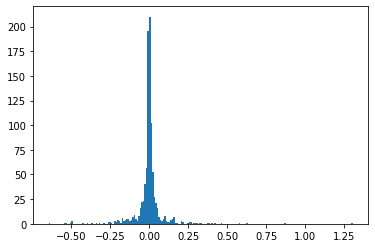

In [121]:
# because we have so many features (n=952), first plot the distribution of feature coeffs across all features
# sort values from high to low
featCoeffs = featCoeffs.sort_values("Feature Coefficient", ascending = False)
plt.hist(featCoeffs["Feature Coefficient"], bins = 200)
plt.show()

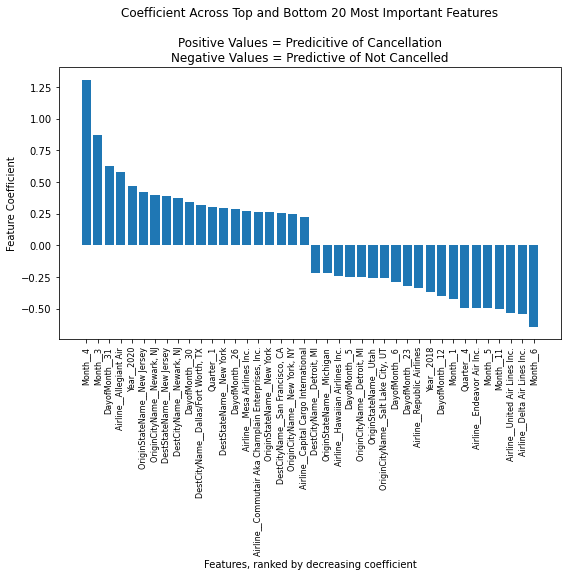

In [156]:
# plot the top 20 features predictie of cancelled flights (pos coeffs) and not cancelled flights (neg coeffs)
nfeats = 20
top_N = pd.concat([featCoeffs.head(nfeats),featCoeffs.tail(nfeats)])
plt.figure(figsize = [9, 5])
plt.bar(top_N.index, top_N["Feature Coefficient"])
plt.xticks(fontsize = 8, rotation = 90)
plt.ylabel("Feature Coefficient")
plt.title("Coefficient Across Top and Bottom 20 Most Important Features\n\nPositive Values = Predicitive of Cancellation\nNegative Values = Predictive of Not Cancelled")
plt.xlabel("Features, ranked by decreasing coefficient")
plt.show()

In [159]:
# save feature coeffs to file
featCoeffs = featCoeffs.reset_index().rename(columns={"index":"Feature"})
featCoeffs.insert(0, "Method", "LogisticRegression")
featCoeffs.to_csv("../results/LogisiticRegression_FeatureImportance.csv")
featCoeffs.head()

,Method,Feature,Feature Coefficient
0,LogisticRegression,Month__4,1.305623
1,LogisticRegression,Month__3,0.871320
2,LogisticRegression,DayofMonth__31,0.629113
3,LogisticRegression,Airline__Allegiant Air,0.576556
4,LogisticRegression,Year__2020,0.466339
...,...,...,...
947,LogisticRegression,Month__5,-0.498242
948,LogisticRegression,Month__11,-0.504762
949,LogisticRegression,Airline__United Air Lines Inc.,-0.534362
950,LogisticRegression,Airline__Delta Air Lines Inc.,-0.544672


# 5.0) Naive Bayes

https://www.kaggle.com/code/prashant111/naive-bayes-classifier-in-python

From the logistic regression above, we know that the two continuous variables (CRSDeptTime & Flight distance) are not very useful in predicited value, we can either (1) exclude them or (2) trasform the continuous values into discrete values (ie, use tertiles to split flight distance into short, medium and long catgeories instead of continuous values). For now, lets exclude the two cont variables. 

1. Gaussian Naive Bayes --> continuous variables, not appropiate for this use case since we have mainly categorical
2. Bernoulli Naïve Bayes --> boolean categorical vairables, this is most appropiate for our data\


https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html (bckground)
https://www.datacamp.com/tutorial/naive-bayes-scikit-learn (tutorial)

## 5.1) Encode categorical variables

Need to convert string labels into numbers using scikit-learn LabelEncoder. do this on all the data, not train and test separately because then the cateogies might not line up after encoding. Can split into same train and test using the index after the encoding step. 

In [221]:
# define varaibles we want to use in bayes classifier
# aka everythin except the continuous ones
bayes_features = ['Airline', 'OriginStateName', 'OriginCityName', 'DestCityName',
                 'DestStateName', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek'
                ]

In [222]:
# # create labelEncoder
# labelEncoder = preprocessing.LabelEncoder()

# # Convert string labels into numbers
# features_encoded = {}
# for feat in bayes_features:
#     features_encoded[feat] = labelEncoder.fit_transform(data[feat].astype(str))

In [228]:
# use ordinal encoder to convert string labels into numbers
data_encoded = OrdinalEncoder()
data_encoded = data_encoded.fit_transform(data[bayes_features])

In [242]:
# split the encoded data into same test and train datasets used above in l.regression
train_data_encoded = data_encoded[train_data.index]
display(train_data_encoded.shape)

test_data_encoded = data_encoded[test_data.index]
display(test_data_encoded.shape)

(320000, 10)

(80000, 10)

## 5.2) Build CategoricalNB model & predict

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB

In [256]:
# initalize
catNB = CategoricalNB()

In [257]:
# fit model
X = train_data_encoded
y = np.array(train_data["Cancelled"])
catNB = catNB.fit(X, y)

In [258]:
# predict on test values
predictions_catNB = catNB.predict(test_data_encoded)

In [259]:
display(list(predictions_catNB).count(0))
list(predictions_catNB).count(1)

79701

299

In [262]:
# save predictions
prediction_results = test_data["Cancelled"].to_frame("Actual Label")
prediction_results = prediction_results.reset_index().rename(columns={"index": "Original Row Number"})
prediction_results["Predicited Label"] = predictions_catNB
prediction_results.insert(0, "Method", "Categorical Naive Bayes")
prediction_results.to_csv("../results/CategoricalNaiveBayes_Predictions.csv")
prediction_results.head(3)

,Method,Original Row Number,Actual Label,Predicited Label
0,Categorical Naive Bayes,386128,0,0
1,Categorical Naive Bayes,297944,0,0
2,Categorical Naive Bayes,164196,0,0


## 5.3) Evaluate model & predictions


In [268]:
accuracy_score(test_data["Cancelled"],  predictions_catNB)

0.970675

In [264]:
print(classification_report(test_data["Cancelled"], predictions_catNB))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     77701
           1       0.42      0.05      0.10      2299

    accuracy                           0.97     80000
   macro avg       0.70      0.53      0.54     80000
weighted avg       0.96      0.97      0.96     80000



# 6.0) Random Forest

https://www.geeksforgeeks.org/random-forest-classifier-using-scikit-learn/

https://datagy.io/sklearn-random-forests/ --> good example of RF on a dataset with continuous and categorical dataset

Similar to logisitc regression, we need to "one hot encode" the categorical variables where we turn each value in a caolumn into its own boolean column. We use one hot because the values within a feature does not have a ranking relationship.

## 6.1) One-hot encode categorical features

Already did this in logisitc regression section, reusing dfs here

In [274]:
train_data_rf = train_data_lr
test_data_rf = test_data_lr

## 6.2) Build Random Forest model & predict

https://datagy.io/sklearn-random-forests/

In [278]:
# initiate model
rf = RandomForestClassifier(n_estimators=100, random_state=100)

In [279]:
# fit model on training data
X = train_data_rf.iloc[:, :-1]
y = np.array(train_data_rf["Cancelled"])
rf.fit(X, y)

RandomForestClassifier(random_state=100)

In [280]:
# predict on testing data
predictions_rf = rf.predict(test_data_rf.iloc[:, :-1])

In [281]:
# quick look at the predictions
display(list(predictions_rf).count(0))
list(predictions_rf).count(1)

79555

445

In [282]:
# save predictions
# save predictions
prediction_results = test_data_rf["Cancelled"].to_frame("Actual Label")
prediction_results = prediction_results.reset_index().rename(columns={"index": "Original Row Number"})
prediction_results["Predicited Label"] = predictions_rf
prediction_results.insert(0, "Method", "RandomForest")
prediction_results.to_csv("../results/RandomForest_Predictions.csv")
prediction_results.head(3)

,Method,Original Row Number,Actual Label,Predicited Label
0,RandomForest,386128,0,0
1,RandomForest,297944,0,0
2,RandomForest,164196,0,0


## 6.3) Evaluate model and predictions 


In [283]:
print(classification_report(test_data_rf["Cancelled"], predictions_rf))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     77701
           1       0.61      0.12      0.20      2299

    accuracy                           0.97     80000
   macro avg       0.79      0.56      0.59     80000
weighted avg       0.96      0.97      0.96     80000



# 6.4) Feature importance

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

Two ways to assess feature importance of random forest: (1) mean decrease in impurity and (2) permutation. 

### 6.4.1) Mean decrease in impurity

In [285]:
# get importances and standard deviation from our RF model
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

In [303]:
# turn into data frame
rf_importances = rf_importances.to_frame("FeatureImportance_MDI")
rf_importances["std"] = std
rf_importances.head(3)

,FeatureImportance_MDI,std
Airline__Air Wisconsin Airlines Corp,0.001798,0.000440
Airline__Alaska Airlines Inc.,0.001839,0.000527
Airline__Allegiant Air,0.002795,0.001101


In [305]:
# # plot
rf_importances = pd.Series(importances, index=rf.feature_names_in_)
# fig, ax = plt.subplots()
# rf_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

In [306]:
# save feature coeffs to file
rf_importances = rf_importances.reset_index().rename(columns={"index":"Feature"})
rf_importances.insert(0, "Method", "RandomForest_MDI")
rf_importances.to_csv("../results/RandomForest_MDI_FeatureImportance.csv")
rf_importances.head()


,Method,Feature,FeatureImportance_MDI,std
0,RandomForest_MDI,Airline__Air Wisconsin Airlines Corp,0.001798,0.000440
1,RandomForest_MDI,Airline__Alaska Airlines Inc.,0.001839,0.000527
2,RandomForest_MDI,Airline__Allegiant Air,0.002795,0.001101
3,RandomForest_MDI,Airline__American Airlines Inc.,0.007006,0.001343
4,RandomForest_MDI,Airline__Cape Air,0.000001,0.000009


In [ ]:
# perm_importances = pd.Series(result.importances_mean, index=rf.feature_names_in_)

In [310]:
# save feature coeffs to file
# perm_importances = perm_importances.reset_index().rename(columns={"index":"Feature"})
# perm_importances.insert(0, "Method", "RandomForest_Permutation")
# # perm_importances.to_csv("../results/RandomForest_per_FeatureImportance.csv")
# perm_importances.head()

# Next....evaluate and compare classifiers
> accuracy, recall, precision, ROC, AUC, confusion matrix,plotting